In [1]:
import re
import glob
import pywt

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV


import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

/Users/user/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Concatenate all the files

In [2]:
# get path to all files
path = 'data/spectra/simulated_data_10K/'

files = sorted(glob.glob(path + 'model_parameters_data*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))

output_path = 'data/params/'
write_data = open(output_path + 'model_parameters_data_all_5K.txt', 'w')

# read in all files
for file in files:
    with open(file, 'r') as f:
        # skip the first 10 lines in each file
        for i in range(10):
            f.readline()
        # read in the data from each file
        data = f.readlines()
        # write the data to the output file in the same order as the files
        for i in range(len(data)):
            write_data.write(data[i])

write_data.close()  

In [3]:
# get the params data
df_param = pd.DataFrame()
for file in files:
    # get the parameters used
    df_param = df_param.append(pd.read_csv(file, skiprows=1, nrows=6, header=None, sep=' ', names=['A', 'B', 'C', 'D']))
    # save the dataframe to a csv file
df_param.to_csv(output_path + 'model_parameters_data_10K.csv', index=False)

#### Load the files 

In [4]:
df_data = pd.read_csv(output_path + 'model_parameters_data_all_10K.txt', sep=' ', header=None) # all data dataframe
df_data.head()

,0,1
0,238.60000,0.0
1,238.60001,0.0
2,238.60002,0.0
3,238.60003,0.0
4,238.60004,0.0


In [5]:
df_data.shape

(580000000, 2)

In [6]:
df_param = pd.read_csv(output_path + 'model_parameters_data_10K.csv')
df_param.head()

,A,B,C,D
0,tcmb,=,2.730000e+00,K
1,ntot,=,5.888377e+17,cm-2
2,tex,=,3.929676e+02,K
3,fwhm,=,1.104218e+00,km/s
4,vlsr,=,7.965879e+01,km/s


In [7]:
# drop the second and fourth column
df_param.drop(['B', 'D'], axis=1, inplace=True)

In [8]:
# transform the data to the right dataframe
df_param = df_param.assign(g = df_param.groupby('A').cumcount()).pivot(index='g', columns='A', values='C')

In [9]:
df_param.head(10)

A,fwhm,ntot,size,tcmb,tex,vlsr
g,,,,,,
0,1.104218,5.888377e+17,0.365643,2.73,392.967603,79.658791
1,1.311138,2.510638e+17,1.193705,2.73,209.445129,24.579956
2,6.637987,7.819653e+16,1.493372,2.73,120.944377,89.281443
3,4.578995,6.434423e+16,1.694034,2.73,139.142766,56.959016
4,3.581212,1.328970e+16,0.798906,2.73,301.743569,35.268285
5,9.396579,2.051602e+17,1.394765,2.73,173.831739,-13.857208
6,5.535242,2.884339e+16,1.799545,2.73,76.906965,45.644163
7,7.010329,2.162035e+17,2.369049,2.73,365.886855,127.833799
8,9.328934,9.712072e+16,0.482378,2.73,274.095481,71.392899


In [10]:
df_param.columns

Index(['fwhm', 'ntot', 'size', 'tcmb', 'tex', 'vlsr'], dtype='object', name='A')

In [11]:
columns = ['Frequency', 'Intensity']
df_data.columns = columns
df_data.shape

(580000000, 2)

In [12]:
df_data.head()

,Frequency,Intensity
0,238.60000,0.0
1,238.60001,0.0
2,238.60002,0.0
3,238.60003,0.0
4,238.60004,0.0


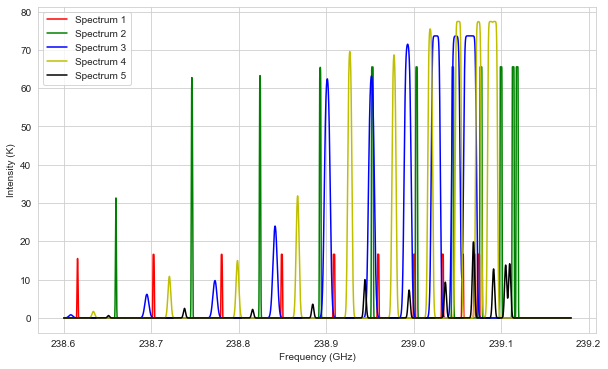

In [13]:
freq_sig = np.array(np.array_split(df_data['Frequency'], len(files)))
signal = np.array(np.array_split(df_data['Intensity'], len(files)))

# plot the signal in one plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(freq_sig[0],  signal[0], color='r', label='Spectrum 1')
plt.plot(freq_sig[1], signal[1], color='g', label='Spectrum 2')
plt.plot(freq_sig[2], signal[2], color='b', label='Spectrum 3')
plt.plot(freq_sig[3], signal[3], color='y', label='Spectrum 4')
plt.plot(freq_sig[4], signal[4], color='k', label='Spectrum 5')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (K)")
plt.legend()
plt.show()

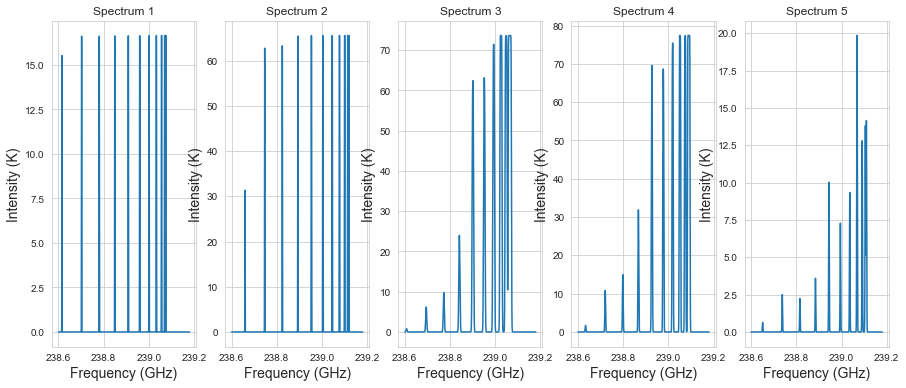

In [14]:
# plot the data in separate plots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
sns.set_style("whitegrid")
for i, ax in enumerate(axes.ravel(), start=1):
    ax.plot(freq_sig[i-1], signal[i-1], label='Spectrum {}'.format(i))
    ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
    ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
    ax.set_title("Spectrum {}".format(i))
    
# plt.savefig('../spectra/simulated_data/spectrum_plots.png')

In [15]:
# print(pywt.wavelist())

### Feature Extraction - Wavelet Decomposition

In [16]:
#create a  feature vector array for each spectrum 
feature_vector = np.zeros((len(signal), int(df_data.shape[0]/len(files))))
detail_coeffs = np.zeros((len(signal), 907))
approx_coeffs = np.zeros((len(signal), 907))
level = 6
wname = 'coif6'
def decompose_signal_dwt(_signal, wavelet=wname, mode='per', level=level):
    """
    Performs wavelet denoising on the given signal.
    """
    # loop throuh all the spectra 
    for spectra_index in range(len(_signal)):
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        coeffs = pywt.wavedec(_signal[spectra_index], wavelet=wavelet, mode=mode, level=level)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        detail_coeffs[spectra_index, :] = coeff_arr[coeff_slices[1]['d']] # 4th level detail coeffs 
        # get the approximation coeffs
        approx_coeffs[spectra_index, :] = coeffs[0] # 4th level approximation coeffs
        
        reconstructed_signal = pywt.waverec(coeffs, wavelet=wavelet, mode=mode)
        feature_vector[spectra_index, :] = coeff_arr[:int(df_data.shape[0]/len(files))]
        # add the coeff_arr to the dataframe for each spectra
        # df_data['fv_dwt_{}'.format(wavelet)] = pd.Series(feature_vector.reshape(1, -1)[0], index=df_data.index) #TODO: find a way to optimize (or comment it out)
        
    return coeff_arr, coeff_slices

In [17]:
feature_vector.shape

(10000, 58000)

In [18]:
coeff_arr, coeff_slices = decompose_signal_dwt(signal)
df_data

,Frequency,Intensity
0,238.60000,0.0
1,238.60001,0.0
2,238.60002,0.0
3,238.60003,0.0
4,238.60004,0.0
...,...,...
579999995,239.17995,0.0
579999996,239.17996,0.0
579999997,239.17997,0.0
579999998,239.17998,0.0


In [19]:
detail_coeffs.shape
detail_coeffs

array([[ 0.00000000e+00,  0.00000000e+00, -4.05207595e-55, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.37555489e-03,  3.05787865e-04, -1.77440358e-04, ...,
         1.85245870e-04, -1.96502555e-04,  2.24139576e-03],
       ...,
       [ 6.73892699e+01, -1.38557138e+01,  9.99737602e+00, ...,
        -1.26807965e+01,  1.93295337e+01, -1.53218596e+02],
       [-2.78550665e-18,  5.28012561e-19, -7.49363132e-20, ...,
         1.37992392e-16, -4.38303914e-17,  1.12741106e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Wavelet Decomposition Plots

In [20]:
def decomposed_dwt_detail_coeffs_plots(_signal, wavelet=wname, level=level):
    """
    Plots of the detail coeffs of the signal.
    """
    # plot the reconstructed signal and the original signal in one plot
    for spectra_index in range(len(_signal)):                     
        # compute the maximum useful level of decomposition for each wavelet                        
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        fig, axes = plt.subplots(nrows=1, ncols=level, dpi=400, sharey='none', sharex='all', figsize=(18, 5))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[i]['d']], label='Level {}'.format(i))
            ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
            ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
            ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 
            
        plt.show()

In [21]:
# decomposed_dwt_detail_coeffs_plots(signal) 

In [22]:
# TODO: find a way to plot the detail coefficients of the signal
def decomposed_dwt_approx_coeffs_plots(_signal, wavelet=wname, level=level):
    
    for spectra_index in range(len(_signal)):
        fig, axes = plt.subplots(nrows=1, ncols=level, figsize=(10, 6))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[1]['d']])
            ax.set_title("Spectrum {} approximation coeffiecients at level {} for {} ".format(spectra_index+1, i,  wavelet))
            
        plt.show()

In [23]:
# decomposed_dwt_approx_coeffs_plots(signal)

### Get Features and Labels

In [24]:
# fv = np.zeros((len(signal), int(df.shape[0]/len(files))))
# for spectra_index in range(len(signal)):
#     # get the level 3 detail coefficients
#     detail_coeffs = coeff_arr[coeff_slices[3]['d']]

# fv  = detail_coeffs
# labels =dff

In [25]:
# len(signal)

approx_coeffs.shape

(10000, 907)

 #### Have a glimpse look at any of the signal and its generated detail and approximation coefficients 

In [26]:

# for spectra_index in range(len(signal)):                     
#         # compute the maximum useful level of decomposition for each wavelet                        
#         # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
#         fig, axes = plt.subplots(nrows=1, ncols=10, sharey='none', sharex='all', figsize=(20, 7))
#         sns.set_style("whitegrid")
#         for i, ax in enumerate(axes.ravel(), start=1):
#             ax.plot(signal[spectra_index], label='Spectrum {}'.format(spectra_index))
#             # ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
#             # ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
#             # ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 

#     # ax[0,1].plot(signal[spectra_index], label='original')
#     # ax[1,1].plot(approx_coeffs[spectra_index], label='spectrum {} approx coeff'.format(spectra_index+1))
#     # ax[2,1].plot(detail_coeffs[spectra_index], label='spectrum {} detail coeff'.format(spectra_index+1))
# plt.legend()
# plt.show()

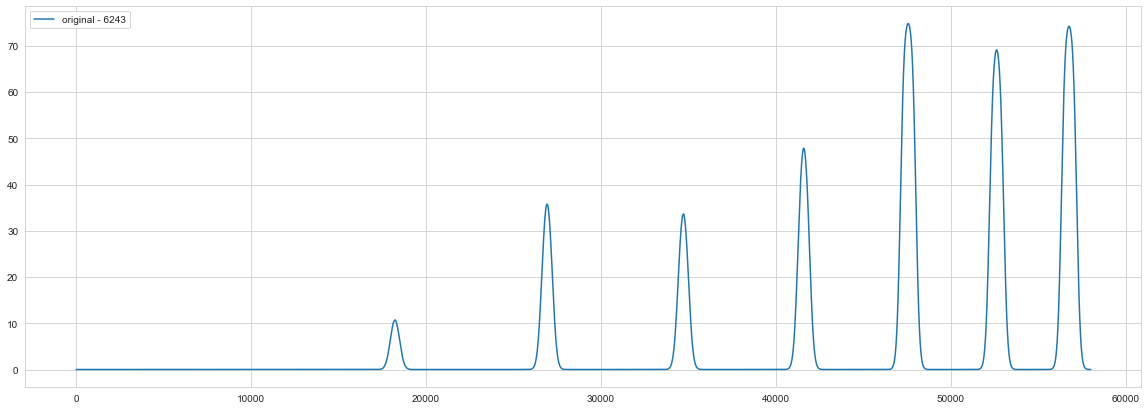

In [27]:
plt.figure(figsize=(20,7))
plt.plot(signal[6243], label='original - 6243')
plt.legend()
plt.savefig("data/10K_gen_files/original.png")
plt.show()

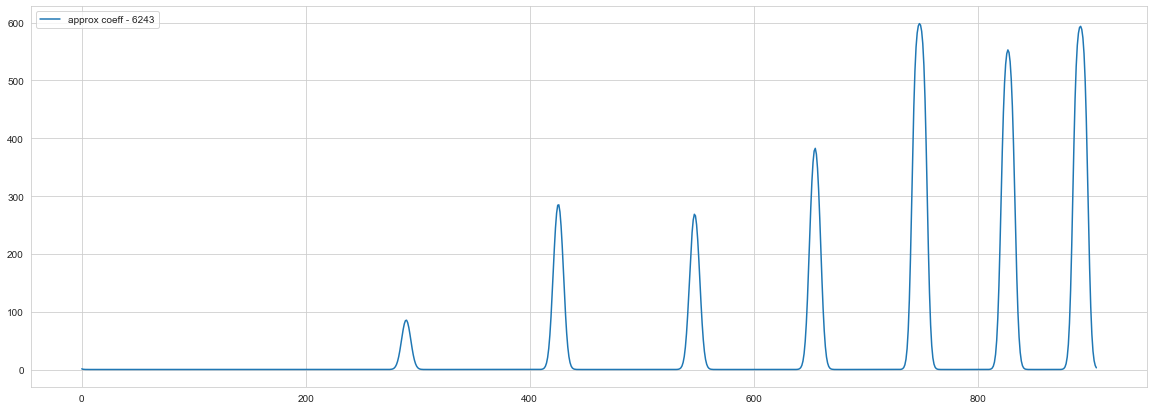

In [28]:
plt.figure(figsize=(20,7))
plt.plot(approx_coeffs[6243], label='approx coeff - 6243')
plt.legend()
plt.savefig("data/10K_gen_files/approx_level6.png")
plt.show()

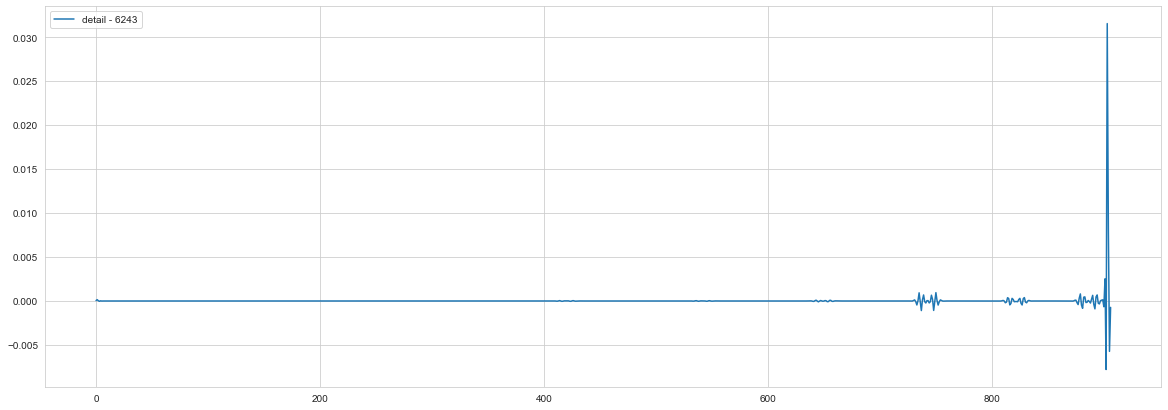

In [29]:
plt.figure(figsize=(20,7))
plt.plot(detail_coeffs[6243], label='detail - 6243')
plt.legend()
plt.savefig("data/10K_gen_files/detail_level6.png")
plt.show()

In [30]:
features = detail_coeffs
labels_ = df_param

print('feature_shape: ', features.shape, 'labels_shape: ', labels_.shape)


feature_shape:  (10000, 907) labels_shape:  (10000, 6)


In [31]:
# drop the tcmb column
labels_.drop(columns=['tcmb'], inplace=True)

#### save the true params to a file

In [32]:
df = pd.DataFrame(approx_coeffs)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,897,898,899,900,901,902,903,904,905,906
0,0.000000,0.000000,-4.236853e-59,-1.700942e-46,-5.867105e-42,-1.131871e-35,-1.579997e-31,-1.709550e-30,-1.828596e-26,1.478300e-21,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
1,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
2,-0.000017,0.000051,-1.355962e-04,3.613813e-04,-9.806227e-04,8.090383e-03,3.189991e-02,7.606479e-02,1.717340e-01,3.561268e-01,...,1.052277e-15,2.094833e-13,-3.639334e-12,3.274123e-11,-3.293064e-10,3.818465e-09,-3.575151e-08,2.488638e-07,-0.000001,0.000005
3,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
4,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000


In [33]:
df = pd.concat([df, labels_], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,902,903,904,905,906,fwhm,ntot,size,tex,vlsr
0,0.000000,0.000000,-4.236853e-59,-1.700942e-46,-5.867105e-42,-1.131871e-35,-1.579997e-31,-1.709550e-30,-1.828596e-26,1.478300e-21,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.104218,5.888377e+17,0.365643,392.967603,79.658791
1,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.311138,2.510638e+17,1.193705,209.445129,24.579956
2,-0.000017,0.000051,-1.355962e-04,3.613813e-04,-9.806227e-04,8.090383e-03,3.189991e-02,7.606479e-02,1.717340e-01,3.561268e-01,...,3.818465e-09,-3.575151e-08,2.488638e-07,-0.000001,0.000005,6.637987,7.819653e+16,1.493372,120.944377,89.281443
3,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,4.578995,6.434423e+16,1.694034,139.142766,56.959016
4,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,3.581212,1.328970e+16,0.798906,301.743569,35.268285


In [34]:
df.shape

(10000, 912)

#### Filter the data ----> VSLR > - 60 km/s

In [35]:
# drop the values less than -60 in the vlsr column
# df = df.drop(df[df['vlsr'] < -60].index)
df = df[df['vlsr']>-60].reset_index(drop=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,902,903,904,905,906,fwhm,ntot,size,tex,vlsr
0,0.000000,0.000000,-4.236853e-59,-1.700942e-46,-5.867105e-42,-1.131871e-35,-1.579997e-31,-1.709550e-30,-1.828596e-26,1.478300e-21,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.104218,5.888377e+17,0.365643,392.967603,79.658791
1,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.311138,2.510638e+17,1.193705,209.445129,24.579956
2,-0.000017,0.000051,-1.355962e-04,3.613813e-04,-9.806227e-04,8.090383e-03,3.189991e-02,7.606479e-02,1.717340e-01,3.561268e-01,...,3.818465e-09,-3.575151e-08,2.488638e-07,-0.000001,0.000005,6.637987,7.819653e+16,1.493372,120.944377,89.281443
3,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,4.578995,6.434423e+16,1.694034,139.142766,56.959016
4,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,3.581212,1.328970e+16,0.798906,301.743569,35.268285


In [36]:
df.shape

(7327, 912)

In [37]:
# get the last 1104 data of the parameters from labels 
df_param = df.iloc[-2199:, -5:]
# save the vals to a csv file
df_param.to_csv("data/10K_gen_files/true_param_vals_less.csv")
df_param.head()

,fwhm,ntot,size,tex,vlsr
5128,7.707931,1.936188e+17,2.059785,152.172307,26.888122
5129,1.711853,1.111263e+17,0.425694,372.263135,126.364836
5130,7.914185,1.313275e+17,0.311055,233.724111,85.538042
5131,2.352107,1.642086e+16,2.294238,355.249228,-58.704470
5132,7.994026,2.960686e+17,0.500270,313.814547,41.541589


In [38]:
# convert the ntot column to log values 
df['ntot'] = np.log10(df['ntot'])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,902,903,904,905,906,fwhm,ntot,size,tex,vlsr
0,0.000000,0.000000,-4.236853e-59,-1.700942e-46,-5.867105e-42,-1.131871e-35,-1.579997e-31,-1.709550e-30,-1.828596e-26,1.478300e-21,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.104218,17.769996,0.365643,392.967603,79.658791
1,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.311138,17.399784,1.193705,209.445129,24.579956
2,-0.000017,0.000051,-1.355962e-04,3.613813e-04,-9.806227e-04,8.090383e-03,3.189991e-02,7.606479e-02,1.717340e-01,3.561268e-01,...,3.818465e-09,-3.575151e-08,2.488638e-07,-0.000001,0.000005,6.637987,16.893187,1.493372,120.944377,89.281443
3,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,4.578995,16.808510,1.694034,139.142766,56.959016
4,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,3.581212,16.123515,0.798906,301.743569,35.268285


In [39]:
X = df.iloc[:, :907]
y = df.iloc[:, -5:]

In [40]:
X

,0,1,2,3,4,5,6,7,8,9,...,897,898,899,900,901,902,903,904,905,906
0,0.000000e+00,0.000000e+00,-4.236853e-59,-1.700942e-46,-5.867105e-42,-1.131871e-35,-1.579997e-31,-1.709550e-30,-1.828596e-26,1.478300e-21,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,-1.724022e-05,5.141306e-05,-1.355962e-04,3.613813e-04,-9.806227e-04,8.090383e-03,3.189991e-02,7.606479e-02,1.717340e-01,3.561268e-01,...,1.052277e-15,2.094833e-13,-3.639334e-12,3.274123e-11,-3.293064e-10,3.818465e-09,-3.575151e-08,2.488638e-07,-1.295111e-06,5.193909e-06
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7322,6.620640e-02,1.659336e-02,6.868389e-03,2.071544e-03,5.839436e-04,4.550095e-05,-1.714755e-07,-1.131206e-07,-1.011754e-07,5.542424e-08,...,3.011695e+02,2.097239e+02,1.298316e+02,7.146742e+01,3.519208e+01,1.561897e+01,6.287282e+00,2.305136e+00,7.716156e-01,2.359738e-01
7323,3.734433e+02,1.970492e+00,6.425829e+00,-2.453413e+00,6.738316e-01,-1.175423e-01,1.069976e-02,-3.281693e-04,9.151166e-06,3.685110e-06,...,4.918665e+02,4.704441e+02,5.126296e+02,2.876407e+02,-1.909970e+01,7.641029e+00,4.707820e+01,4.501451e+02,4.836219e+02,5.003934e+02
7324,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7325,1.148500e-15,-3.537846e-16,1.280122e-16,-2.419984e-17,3.133399e-18,-5.876214e-20,-3.203194e-21,-9.453978e-23,5.576446e-24,-4.530599e-26,...,1.154071e-07,2.313461e-08,4.406776e-09,7.979096e-10,1.374098e-10,2.252140e-11,3.522056e-12,5.235008e-13,7.464218e-14,-8.461201e-16


In [41]:
y

,fwhm,ntot,size,tex,vlsr
0,1.104218,17.769996,0.365643,392.967603,79.658791
1,1.311138,17.399784,1.193705,209.445129,24.579956
2,6.637987,16.893187,1.493372,120.944377,89.281443
3,4.578995,16.808510,1.694034,139.142766,56.959016
4,3.581212,16.123515,0.798906,301.743569,35.268285
...,...,...,...,...,...
7322,6.328143,16.124751,1.783898,120.648623,-37.542690
7323,1.223564,17.881800,1.061621,386.164272,-48.117793
7324,3.510950,16.946165,2.287943,20.132487,57.424608
7325,8.326096,16.379398,1.970493,72.088183,-16.738557


#### split the data into the training and test set

In [42]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    shuffle=False,
    random_state=42
    )

print('X_train shape: ',  X_train.shape, '\n',
    'y_train shape: ', y_train.shape, '\n',
    'X_test shape: ', X_test.shape, '\n',
    'y_test shape: ', y_test.shape)

X_train shape:  (5128, 907) 
 y_train shape:  (5128, 5) 
 X_test shape:  (2199, 907) 
 y_test shape:  (2199, 5)


## 1. Multioutput Regressor - RF

In [43]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

# tuned model to use instantly
regr_multirf = MultiOutputRegressor(
    estimator=RandomForestRegressor(
        bootstrap='False',
        max_depth=90,
        max_features='log2',
        max_samples=0.8999999999999999,
        n_estimators=700,
        n_jobs=-1,
        random_state=7,
        verbose=2
))

# # from tuned model
# regr_multirf = MultiOutputRegressor(
#     estimator=RandomForestRegressor(
#        n_estimators=800, 
#        min_samples_split=2,
#        min_samples_leaf=1,
#        max_features='auto', 
#        max_depth=130,
#        bootstrap=True,
#        verbose=42
#     )
# )


# multioutput regressor+
regr_multirf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 7 of 700
building tree 4 of 700
building tree 5 of 700
building tree 2 of 700
building tree 3 of 700
building tree 6 of 700
building tree 1 of 700
building tree 8 of 700
building tree 13 of 700
building tree 14 of 700
building tree 9 of 700
building tree 11 of 700
building tree 15 of 700
building tree 10 of 700
building tree 12 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s


building tree 59 of 700
building tree 61 of 700
building tree 63 of 700
building tree 65 of 700
building tree 67 of 700
building tree 69 of 700
building tree 71 of 700
building tree 58 of 700
building tree 62 of 700
building tree 64 of 700
building tree 60 of 700
building tree 66 of 700
building tree 68 of 700
building tree 72 of 700
building tree 70 of 700
building tree 73 of 700
building tree 75 of 700
building tree 77 of 700
building tree 79 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 87 of 700
building tree 74 of 700
building tree 80 of 700
building tree 76 of 700
building tree 88 of 700
building tree 82 of 700
building tree 86 of 700
building tree 78 of 700
building tree 84 of 700
building tree 89 of 700
building tree 93 of 700
building tree 97 of 700
building tree 101 of 700
building tree 105 of 700
building tree 109 of 700
building tree 90 of 700
building tree 94 of 700
building tree 98 of 700
building tree 102 of 700
building tre

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    8.2s


building tree 422 of 700
building tree 408 of 700
building tree 411 of 700
building tree 404 of 700
building tree 415 of 700
building tree 419 of 700
building tree 426 of 700
building tree 412 of 700
building tree 423 of 700
building tree 430 of 700
building tree 416 of 700
building tree 420 of 700
building tree 427 of 700
building tree 424 of 700
building tree 433 of 700
building tree 431 of 700
building tree 437 of 700
building tree 441 of 700
building tree 445 of 700
building tree 428 of 700
building tree 432 of 700
building tree 434 of 700
building tree 449 of 700
building tree 438 of 700
building tree 453 of 700
building tree 442 of 700
building tree 446 of 700
building tree 435 of 700
building tree 439 of 700
building tree 457 of 700
building tree 450 of 700
building tree 461 of 700
building tree 454 of 700
building tree 443 of 700
building tree 440 of 700
building tree 436 of 700
building tree 447 of 700
building tree 451 of 700
building tree 455 of 700
building tree 458 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 4 of 700
building tree 3 of 700
building tree 1 of 700
building tree 2 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 20 of 700
building tree 24 of 700
building tree 22 of 700
building tree 26 of 700
building tree 30 of 700
building tree 28 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 34 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s



building tree 51 of 700
building tree 53 of 700
building tree 55 of 700
building tree 57 of 700
building tree 59 of 700
building tree 61 of 700
building tree 50 of 700
building tree 54 of 700
building tree 52 of 700
building tree 63 of 700
building tree 58 of 700
building tree 56 of 700
building tree 60 of 700
building tree 62 of 700
building tree 65 of 700
building tree 67 of 700
building tree 64 of 700
building tree 69 of 700
building tree 71 of 700
building tree 73 of 700
building tree 75 of 700
building tree 77 of 700
building tree 79 of 700
building tree 66 of 700
building tree 68 of 700
building tree 70 of 700
building tree 76 of 700
building tree 78 of 700
building tree 72 of 700
building tree 74 of 700
building tree 80 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 87 of 700
building tree 89 of 700
building tree 91 of 700
building tree 93 of 700
building tree 95 of 700
building tree 86 of 700
building tree 84 of 700
building tree 8

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    2.7s


building tree 307 of 700
building tree 309 of 700
building tree 306 of 700
building tree 311 of 700
building tree 313 of 700
building tree 315 of 700
building tree 317 of 700
building tree 319 of 700
building tree 310 of 700
building tree 308 of 700
building tree 312 of 700
building tree 321 of 700
building tree 314 of 700
building tree 320 of 700
building tree 316 of 700
building tree 318 of 700
building tree 323 of 700
building tree 325 of 700
building tree 322 of 700
building tree 327 of 700
building tree 329 of 700
building tree 331 of 700
building tree 333 of 700
building tree 335 of 700
building tree 326 of 700
building tree 330 of 700
building tree 328 of 700
building tree 324 of 700
building tree 337 of 700
building tree 332 of 700
building tree 334 of 700
building tree 336 of 700
building tree 339 of 700
building tree 341 of 700
building tree 338 of 700
building tree 343 of 700
building tree 345 of 700
building tree 347 of 700
building tree 349 of 700
building tree 351 of 700


[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 3 of 700
building tree 2 of 700
building tree 1 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 20 of 700
building tree 26 of 700
building tree 22 of 700
building tree 30 of 700
building tree 32 of 700
building tree 28 of 700
building tree 24 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 34 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s


building tree 49 of 700
building tree 51 of 700
building tree 53 of 700
building tree 55 of 700
building tree 57 of 700
building tree 59 of 700
building tree 61 of 700
building tree 63 of 700
building tree 50 of 700
building tree 52 of 700
building tree 56 of 700
building tree 58 of 700
building tree 60 of 700
building tree 54 of 700
building tree 64 of 700
building tree 62 of 700
building tree 65 of 700
building tree 67 of 700
building tree 69 of 700
building tree 71 of 700
building tree 73 of 700
building tree 75 of 700
building tree 77 of 700
building tree 79 of 700
building tree 70 of 700
building tree 66 of 700
building tree 68 of 700
building tree 74 of 700
building tree 78 of 700
building tree 72 of 700
building tree 80 of 700
building tree 76 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 87 of 700
building tree 89 of 700
building tree 91 of 700
building tree 93 of 700
building tree 95 of 700
building tree 82 of 700
building tree 84

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.4s


building tree 296 of 700
building tree 298 of 700
building tree 294 of 700
building tree 300 of 700
building tree 302 of 700
building tree 304 of 700
building tree 305 of 700
building tree 307 of 700
building tree 309 of 700
building tree 311 of 700
building tree 313 of 700
building tree 315 of 700
building tree 317 of 700
building tree 319 of 700
building tree 306 of 700
building tree 308 of 700
building tree 312 of 700
building tree 314 of 700building tree 310 of 700

building tree 316 of 700
building tree 320 of 700
building tree 318 of 700
building tree 321 of 700
building tree 323 of 700
building tree 325 of 700
building tree 327 of 700
building tree 329 of 700
building tree 331 of 700
building tree 333 of 700
building tree 335 of 700
building tree 326 of 700
building tree 328 of 700
building tree 322 of 700
building tree 324 of 700
building tree 330 of 700
building tree 332 of 700
building tree 334 of 700
building tree 336 of 700
building tree 337 of 700
building tree 339 of 700


[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    7.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    7.9s finished


building tree 696 of 700
building tree 698 of 700
building tree 697 of 700
building tree 700 of 700
building tree 699 of 700


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 1 of 700
building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 30 of 700
building tree 33 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 34 of 700
building tree 47 of 700
building tree 36 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 60 of 700
building tree 79 of 700
building tree 68 of 700
building tree 64 of 700
building tree 72 of 700
building tree 76 of 700
building tree 80 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 93 of 700
building tree 97 of 700
building tree 82 of 700
building tree 101 of 700
building tree 86 of 700
building tree 105 of 700
building tree 90 of 700
building tree 94 of 700
building tree 109 of 700
building tree 98 of 700
building tree 83 of 700
building tree 87 of 700
building tree 102 of 700
building tree 91 of 700
building tree 106 of 700
building tree 95 of 700
building tree 99 of 700
building tree 110 of 700
building tree 84 of 700
building tree 88 of 700
building tree 103 of 700
building tree 92 of 700
building tree 107 of 700
building tree 96 of 700
building tree 111 of 700
building tree 100 of 700
building tree 104 of 700
building tree 108 of 700
building tree 113 of 700
building tree 112 of 700
building tree 117 of 700
b

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s


building tree 569 of 700
building tree 548 of 700
building tree 558 of 700
building tree 562 of 700
building tree 552 of 700building tree 556 of 700

building tree 566 of 700
building tree 570 of 700
building tree 563 of 700
building tree 559 of 700
building tree 573 of 700
building tree 567 of 700
building tree 577 of 700
building tree 581 of 700
building tree 564 of 700
building tree 560 of 700
building tree 568 of 700
building tree 585 of 700
building tree 574 of 700
building tree 578 of 700
building tree 571 of 700
building tree 582 of 700
building tree 589 of 700
building tree 586 of 700
building tree 575 of 700
building tree 579 of 700
building tree 593 of 700
building tree 583 of 700
building tree 597 of 700
building tree 576 of 700
building tree 587 of 700
building tree 590 of 700
building tree 580 of 700
building tree 572 of 700
building tree 594 of 700
building tree 584 of 700
building tree 598 of 700
building tree 588 of 700
building tree 591 of 700
building tree 601 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 4 of 700
building tree 3 of 700
building tree 2 of 700building tree 6 of 700

building tree 5 of 700building tree 1 of 700

building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 28 of 700
building tree 24 of 700
building tree 26 of 700
building tree 30 of 700
building tree 33 of 700
building tree 32 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 34 of 700
building tree 47 of 700
building tree 36 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 81 of 700
building tree 76 of 700
building tree 80 of 700
building tree 85 of 700
building tree 82 of 700
building tree 86 of 700
building tree 89 of 700
building tree 93 of 700
building tree 97 of 700
building tree 101 of 700
building tree 83 of 700
building tree 105 of 700
building tree 90 of 700
building tree 109 of 700
building tree 87 of 700
building tree 94 of 700
building tree 102 of 700
building tree 98 of 700
building tree 84 of 700
building tree 106 of 700
building tree 91 of 700
building tree 95 of 700
building tree 88 of 700
building tree 110 of 700
building tree 103 of 700
building tree 99 of 700
building tree 107 of 700
building tree 96 of 700
building tree 92 of 700
building tree 113 of 700
building tree 111 of 700
building tree 104 of 700
building tree 100 of 700
building tree 117 of 700
building tree 108 of 700
building tree 112 of 700
building tree 114 of 700
building tree 121 of 700
building tree 125 of 700
building tree 118 of 700
building tree 115 of 

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s



building tree 551 of 700
building tree 536 of 700
building tree 558 of 700
building tree 532 of 700
building tree 540 of 700
building tree 555 of 700
building tree 544 of 700
building tree 548 of 700
building tree 552 of 700
building tree 556 of 700
building tree 559 of 700
building tree 560 of 700
building tree 561 of 700
building tree 565 of 700
building tree 569 of 700
building tree 573 of 700
building tree 577 of 700
building tree 562 of 700
building tree 581 of 700
building tree 585 of 700
building tree 566 of 700
building tree 570 of 700
building tree 574 of 700
building tree 578 of 700
building tree 563 of 700
building tree 582 of 700
building tree 589 of 700
building tree 571 of 700
building tree 586 of 700
building tree 575 of 700
building tree 567 of 700
building tree 583 of 700
building tree 579 of 700
building tree 564 of 700
building tree 590 of 700
building tree 587 of 700
building tree 576 of 700
building tree 568 of 700
building tree 584 of 700
building tree 572 of 700

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    4.3s finished


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap='False',
                                                     max_depth=90,
                                                     max_features='log2',
                                                     max_samples=0.8999999999999999,
                                                     n_estimators=700,
                                                     n_jobs=-1, random_state=7,
                                                     verbose=2))

In [44]:
#  predict on the new test data
y_multirf_pred = regr_multirf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

In [45]:
regr_multirf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

0.7676482206256839

### save the predicted parameters to a csv file 

In [46]:
param_df_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm_rf_pred', 'ntot_rf_pred', 'size_rf_pred', 'tex_rf_pred', 'vlsr_rf_pred'], index=X_test.index)
param_df_rf.head()

,fwhm_rf_pred,ntot_rf_pred,size_rf_pred,tex_rf_pred,vlsr_rf_pred
5128,7.722808,17.544124,1.982629,185.838218,26.863662
5129,2.221764,16.965752,0.695273,213.904494,122.945887
5130,7.999034,16.437213,1.038743,289.552037,85.395651
5131,2.491883,16.735687,0.738482,199.469060,-44.869657
5132,8.230145,17.032737,1.189245,270.874842,41.509863


In [47]:
# convert back the log to linear values 
param_df_rf['ntot_rf_pred'] = np.array(10**param_df_rf['ntot_rf_pred'])

In [48]:
param_df_rf.to_csv('data/10K_gen_files/predicted_parameters_rf_less.csv', index=True)
param_df_rf.shape

(2199, 5)

In [49]:
pred_para = pd.read_csv('data/5K_gen_files/predicted_parameters_rf_less.csv')
true_para = pd.read_csv('data/5K_gen_files/true_param_vals_less.csv')

# add the predicted value to the true value dataframe as new columns separated by an empty column 
true_para = pd.concat([true_para,  pd.DataFrame(np.zeros(len(true_para))), pred_para], axis=1)
true_para.to_csv('data/5K_gen_files/true_param_vals_with_predicted_rf_less.csv')
true_para.head()

,Unnamed: 0,fwhm,ntot,size,tex,vlsr,0,Unnamed: 0,fwhm_rf_pred,ntot_rf_pred,size_rf_pred,tex_rf_pred,vlsr_rf_pred
0,2563,7.694016,1.461373e+16,2.168012,286.961120,-6.008380,0.0,2563,7.060848,3.664819e+16,0.575093,273.576973,-5.916273
1,2564,6.498012,1.634500e+16,2.082718,106.625578,72.382751,0.0,2564,6.416919,3.415073e+16,1.865330,133.708644,72.496934
2,2565,6.281777,2.970838e+16,2.099107,30.884684,-45.662478,0.0,2565,5.640251,7.250558e+16,1.914501,37.244789,-46.183169
3,2566,2.013231,5.106066e+17,0.938084,247.118931,93.531877,0.0,2566,2.885432,1.120083e+17,1.316375,215.571185,94.446795
4,2567,2.130034,1.188721e+17,1.391456,190.289165,37.114075,0.0,2567,2.799813,2.124100e+17,1.494399,198.995359,39.029028


#### Metrics

In [50]:
class RegressionMetrics:
    def __init__(self):
        self.metrics = {
            "mae": self._mean_absolute_error,
            "mse": self._mean_squared_error,
            "rmse": self._root_mean_squared_error,
            "mape": self._mean_absolute_percentage_error,
            "r2": self._r2_score,
            "msle": self._mean_squared_log_error,
            # "rmsle": self._root_mean_squared_logarithmic_error,
        }

    def get_metric(self, metric,  y_true, y_pred):
        if metric not in self.metrics:
            raise Exception("Metric not found")
        
        if metric == "mae":
            return self._mean_absolute_error(y_true, y_pred)
        if metric == "mse":
            return self._mean_squared_error(y_true, y_pred)
        if metric == "rmse":
            return self._root_mean_squared_error(y_true, y_pred)
        if metric == "mape":
            return self._mean_absolute_percentage_error(y_true, y_pred)
        if metric == "r2":
            return self._r2_score(y_true, y_pred)
        if metric == "msle":
            return self._mean_squared_log_error(y_true, y_pred)
        # if metric == "rmsle":
        #     return self._root_mean_squared_logarithmic_error(y_true, y_pred)
        
    @staticmethod
    def _mean_absolute_error(y_true, y_pred):
        return metrics.mean_absolute_error(y_true, y_pred)

    @staticmethod
    def _mean_squared_error(y_true, y_pred):
        return metrics.mean_squared_error(y_true, y_pred)

    def _root_mean_squared_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    def _mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    @staticmethod
    def _r2_score(y_true, y_pred):
        return metrics.r2_score(y_true, y_pred)
    
    def _mean_squared_log_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    
    # TODO: investigate in the case where it gives an error
    # def _root_mean_squared_logarithmic_error(self, y_true, y_pred):
    #     return np.sqrt(np.mean(np.square(np.log(y_pred + 1) - np.log(y_true + 1))))


In [51]:
# get the metricl for the multirf regressor
metrics_multirf = RegressionMetrics()
_metrics = ['mae', 'mse', 'rmse', 'mape', 'r2', 'msle']
for metric in _metrics:
    print("Multirf  {}: ".format(metric), metrics_multirf.get_metric(metric, y_test, y_multirf_pred))

Multirf  mae:  11.183497574862912
Multirf  mse:  897.0845419827052
Multirf  rmse:  29.951369617810556
Multirf  mape:  fwhm     9.152304
ntot     1.679161
size    36.822778
tex     37.546365
vlsr     4.462678
dtype: float64
Multirf  r2:  0.7676482206256839
Multirf  msle:  29.951369617810556


### Predicted vs True values plots

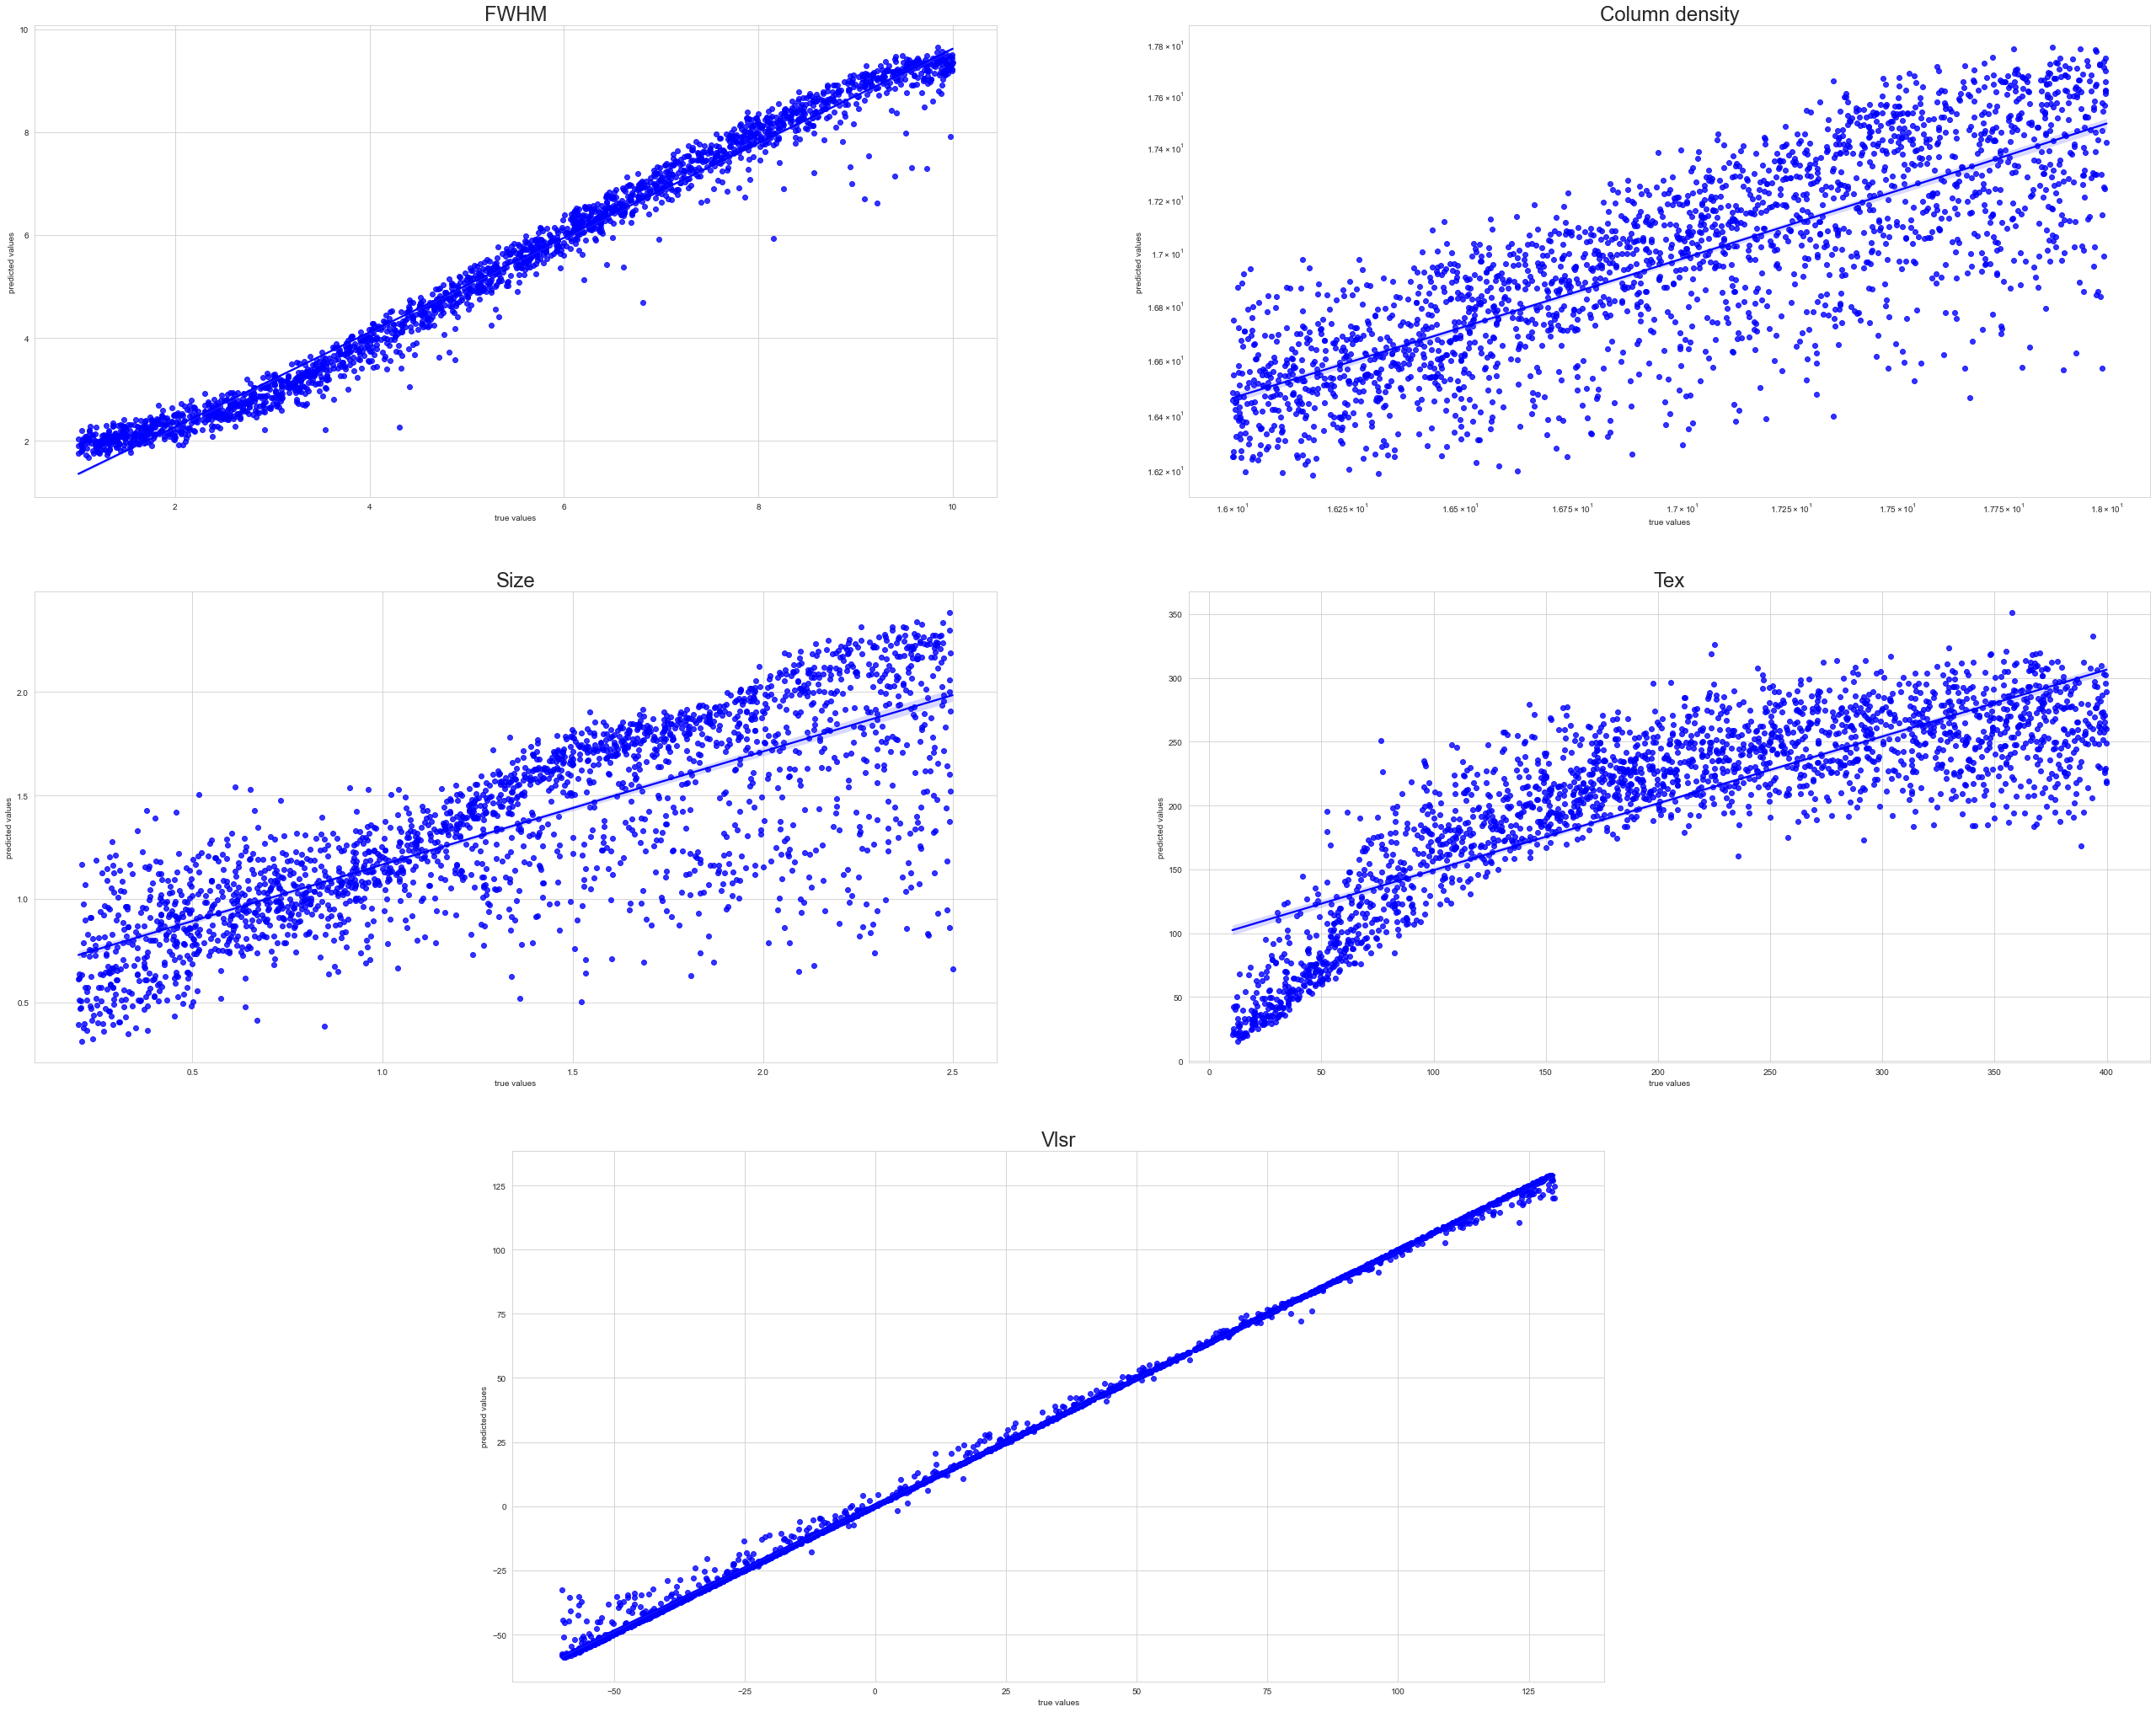

In [52]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_pred[:,0], color='blue', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_pred[:,1], color='blue', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_pred[:,2], color='blue', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_pred[:,3], color='blue', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_pred[:,4], color='blue', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/10K_gen_files/pred_true_10K_RF_less.png")
plt.show()

### 3D plots -  Columnn density, Excitation temperature and Size

In [53]:
pred_param_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_rf.head()

,fwhm,ntot,size,tex,vlsr
0,7.722808,17.544124,1.982629,185.838218,26.863662
1,2.221764,16.965752,0.695273,213.904494,122.945887
2,7.999034,16.437213,1.038743,289.552037,85.395651
3,2.491883,16.735687,0.738482,199.469060,-44.869657
4,8.230145,17.032737,1.189245,270.874842,41.509863


### Residuals 3D plot -  Random Forest Regressor

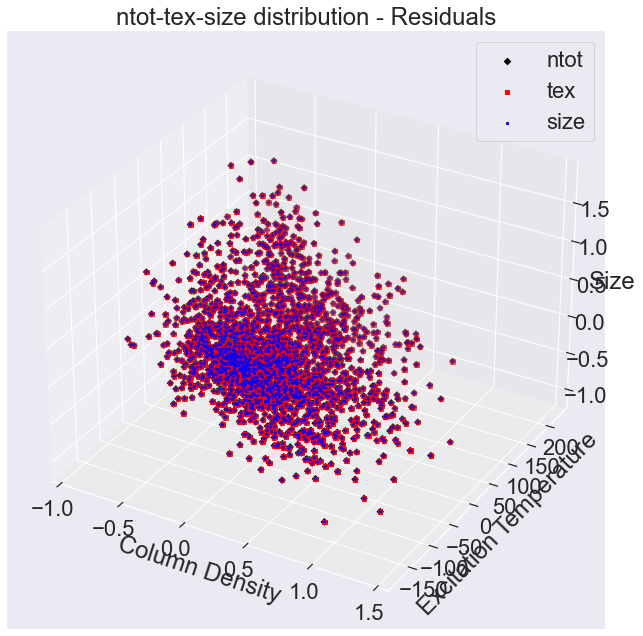

In [54]:
fig = plt.figure(figsize=(26, 11))
plt.setp(ax.get_xticklabels(), fontsize=12)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_rf = (y_test - y_multirf_pred)
# residuals
x1 = residuals_rf['ntot']
y1 = residuals_rf['tex']
z1 = residuals_rf['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

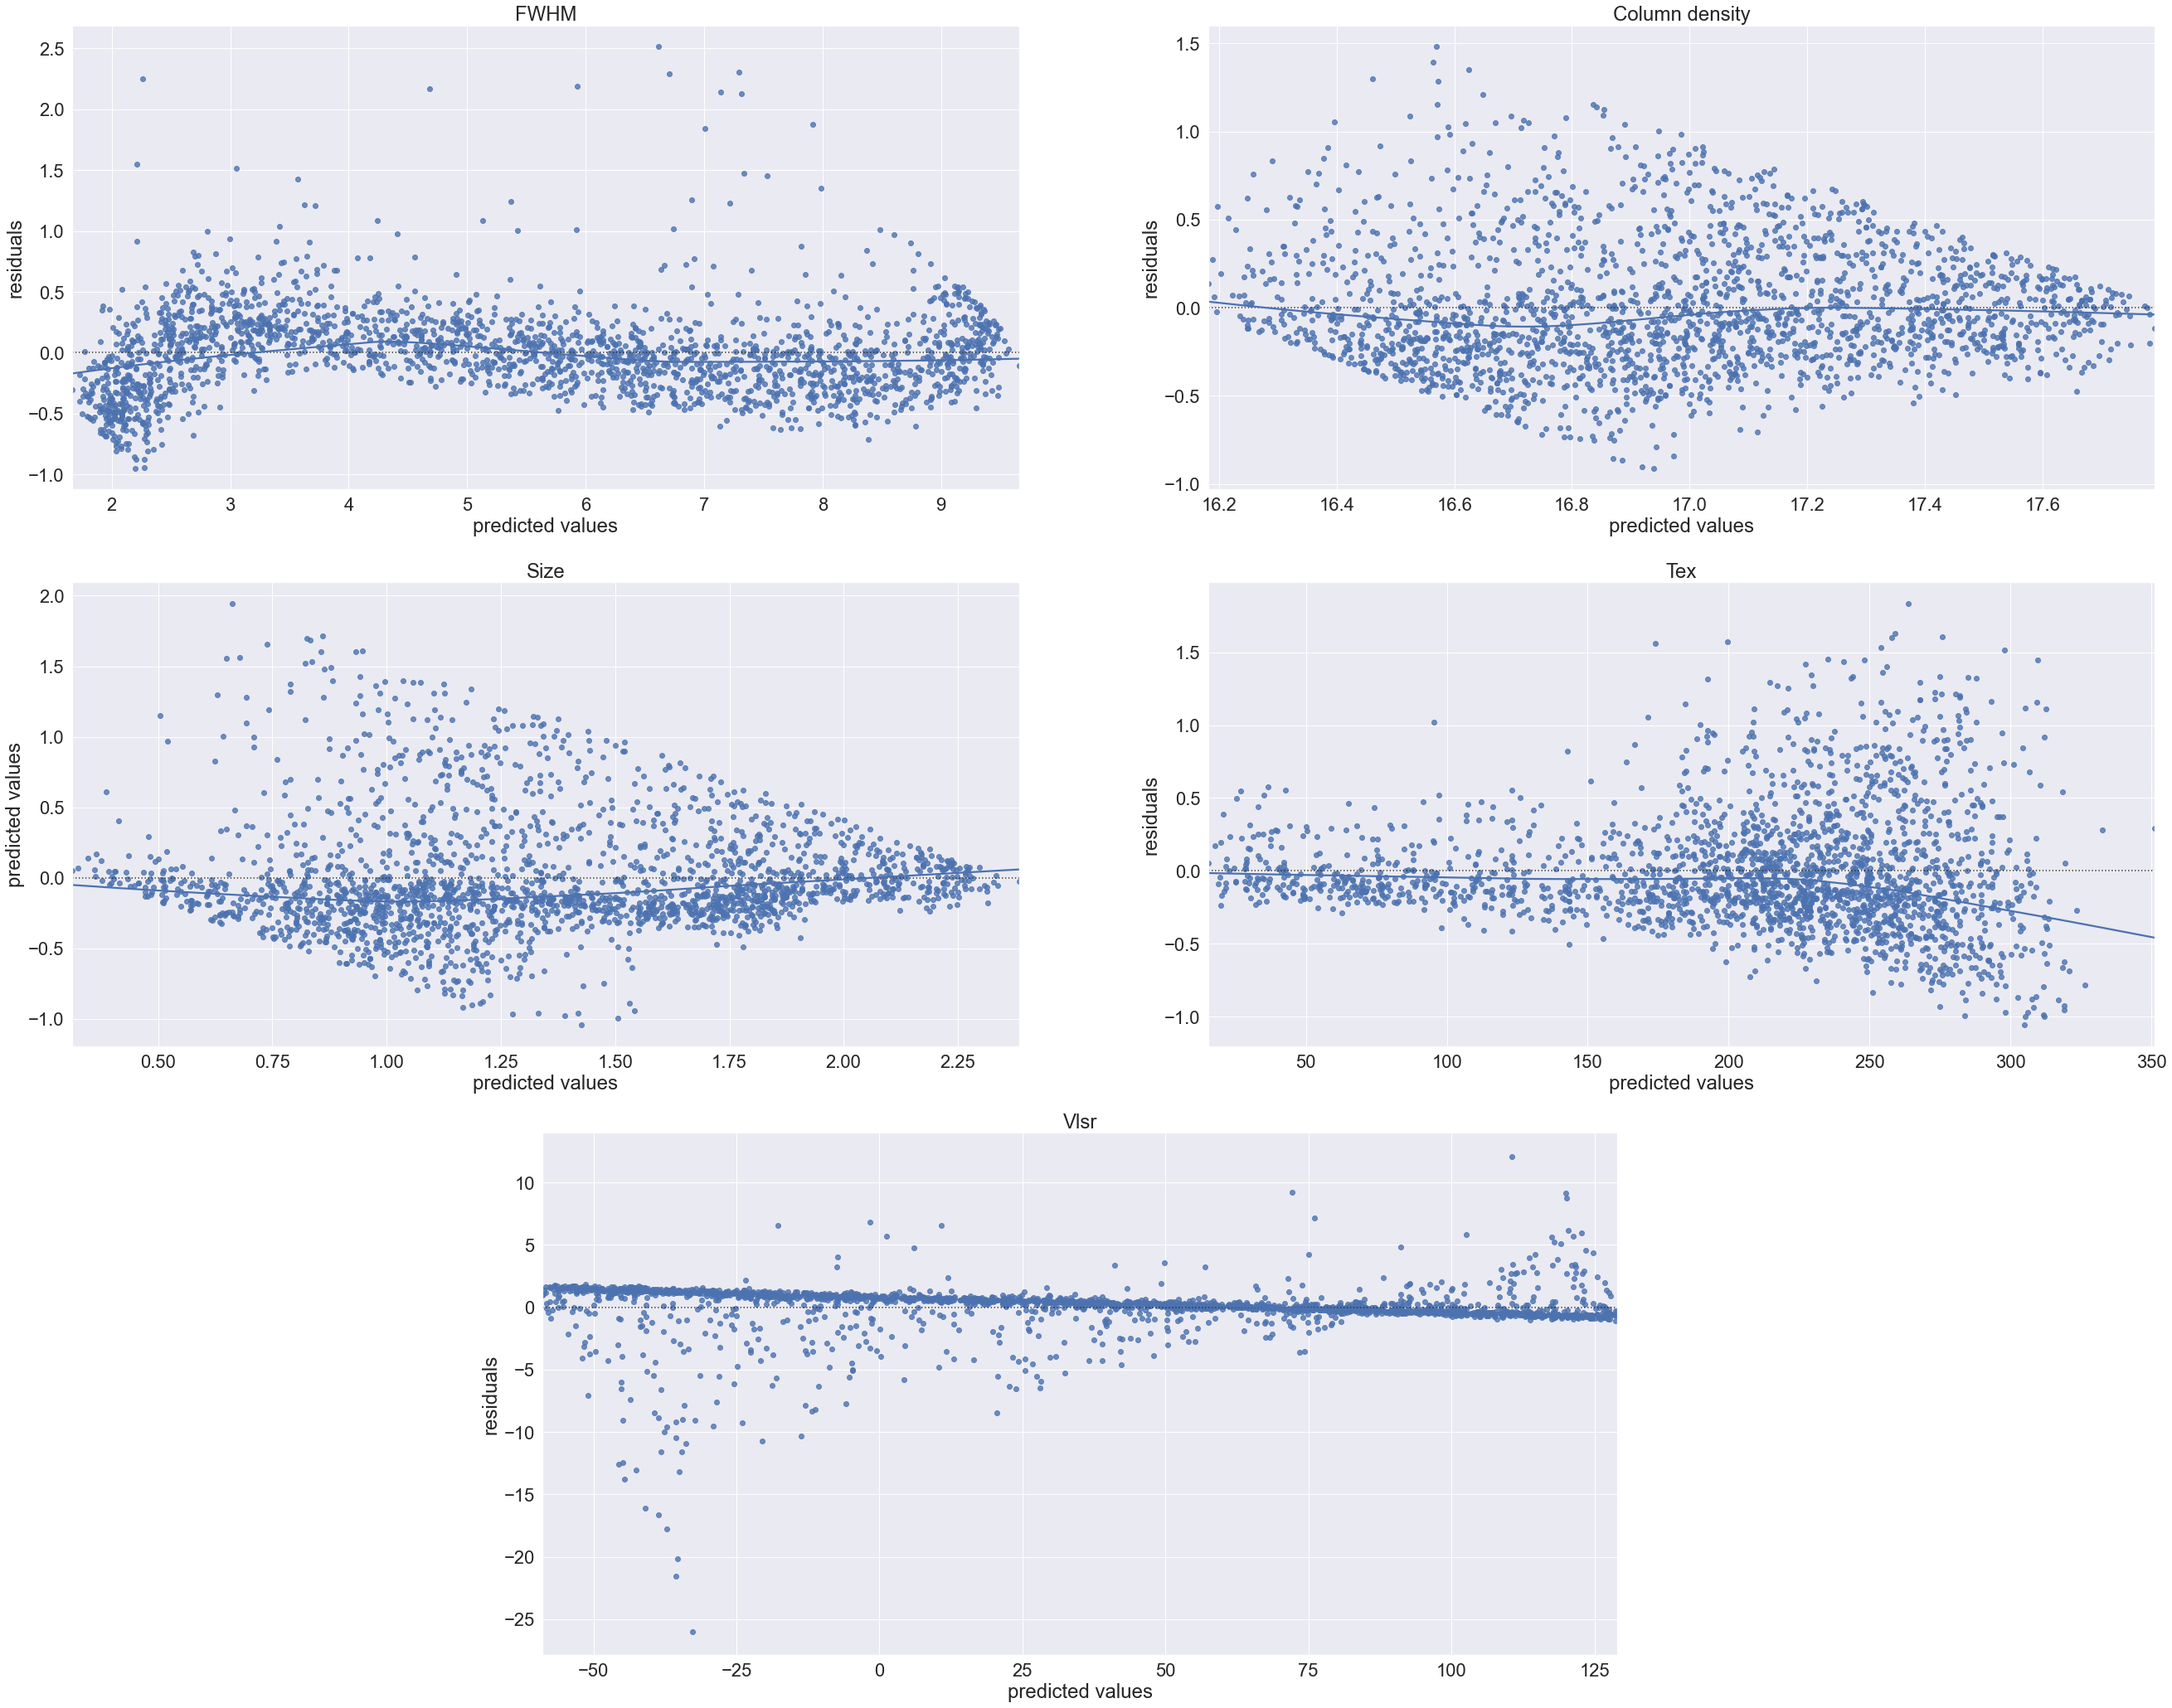

In [55]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multirf_pred[:,0], y=residuals_rf['fwhm'], lowess=True, ax=axes[0,0]) # fwhm
g2 = sns.residplot(x=y_multirf_pred[:,1], y=residuals_rf['ntot'], lowess=True, ax=axes[0,1]) # column density
g3 = sns.residplot(x=y_multirf_pred[:,2], y=residuals_rf['size'], lowess=True, ax=axes[1,0]) # size
g4 = sns.residplot(x=y_multirf_pred[:,3], y=residuals_rf['size'], lowess=True, ax=axes[1,1]) # tex
g5 = sns.residplot(x=y_multirf_pred[:,4], y=residuals_rf['vlsr'], lowess=True, ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/10K_gen_files/residuals_RF_10K_less.png")
plt.show()

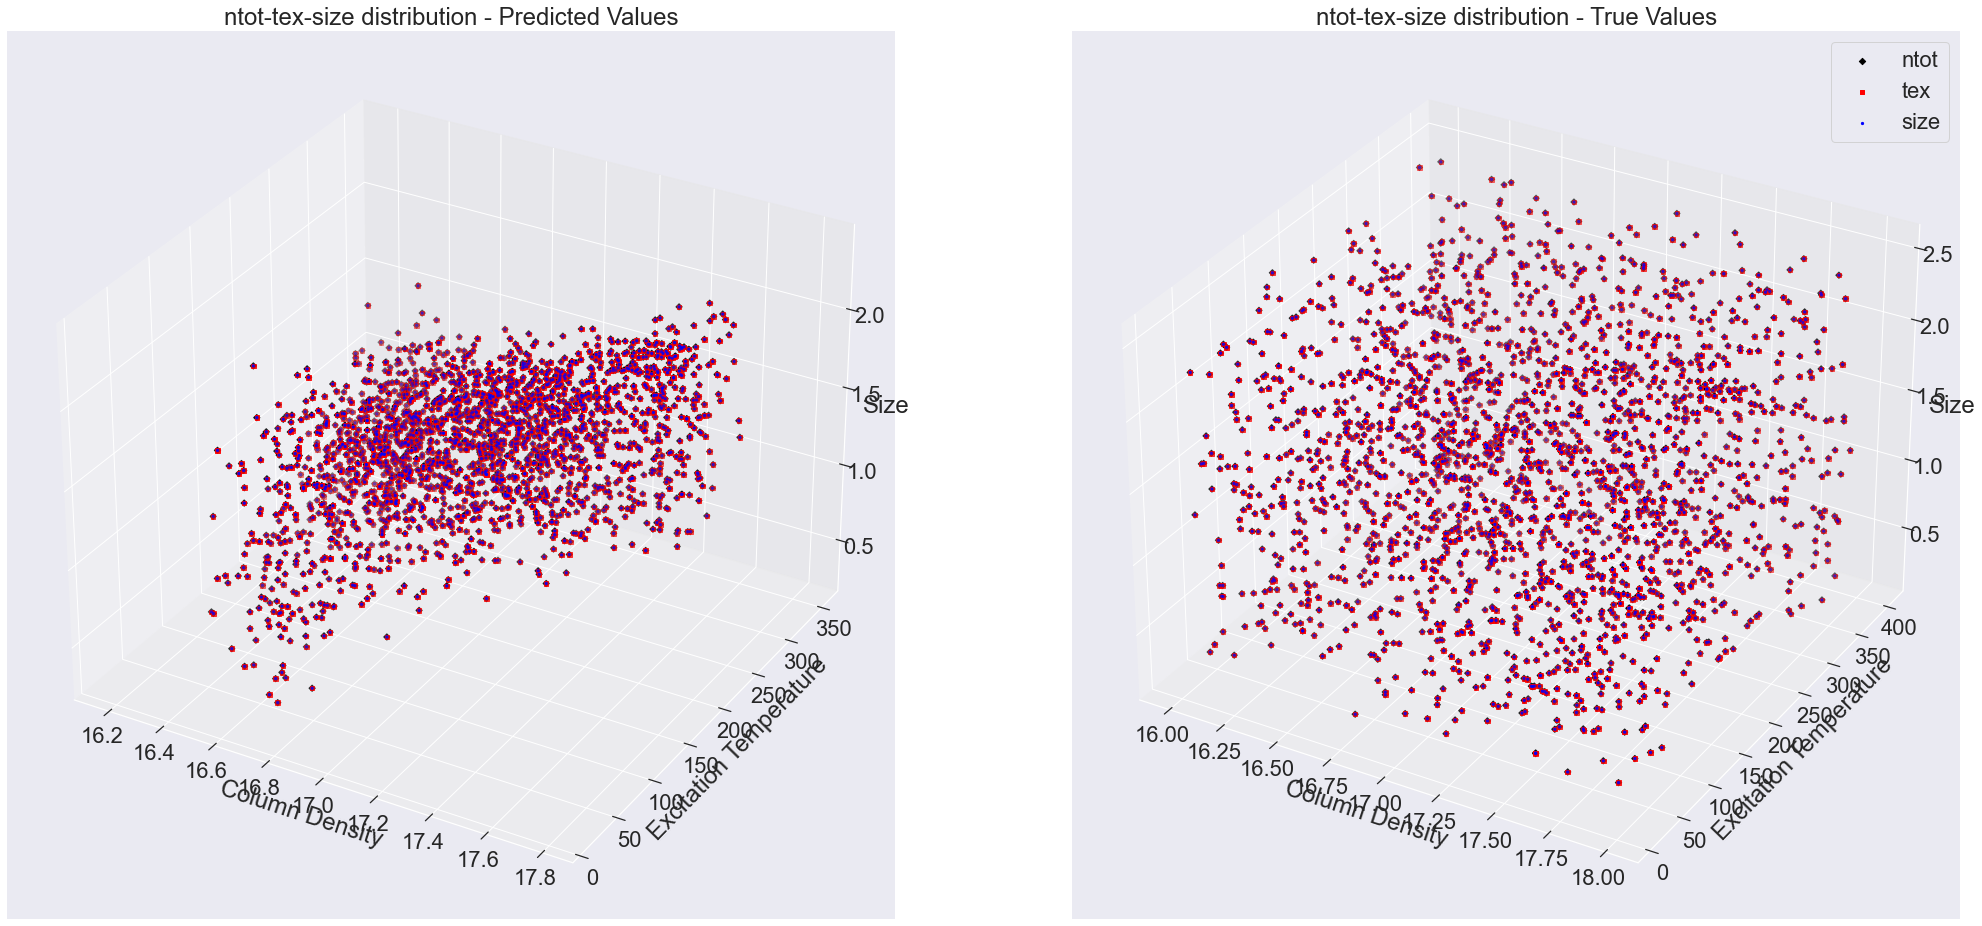

In [56]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    x1 = pred_param_rf['ntot']
    y1 = pred_param_rf['tex']
    z1 = pred_param_rf['size']
    
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density')
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig("data/10K_gen_files/scatter3D_pred_true_10K_RF_less.png")
plt.show()

All the points are taking up the same position in a 3D space. Not sure if this is how its supposed to be. From my understanding, the Column density is dependent on Temperature, so they take the `x`, and `y` positions while size takes the `z` position.plt

## Hyperparameter Tuning for Random Forest

In [57]:
multirf_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        criterion="squared_error",
        bootstrap=True,
        n_jobs=-1,
        max_samples=None,
))

multrf_hyperparameters = dict(
    estimator__n_estimators=np.arange(100, 1000, 100),
    estimator__max_depth=np.arange(10, 150, 10),
    estimator__min_samples_split=np.arange(2, 10, 2),
    estimator__min_samples_leaf=np.arange(1, 5, 1),
    # estimator__min_weight_fraction_leaf=np.arange(0, 0.5, 0.1),
    # estimator__criterion=["squared_error", "absolute_error"],
    estimator__max_features=["auto", "sqrt", "log2"],
    # estimator__max_samples=np.arange(0.5, 1, 0.1),
    estimator__bootstrap=["True", "False"]
    )

In [58]:
regr_tuned_multirf = RandomizedSearchCV(
    estimator=multirf_model,
    param_distributions=multrf_hyperparameters,
    n_iter=100,
    cv=5,
    verbose=2,
    error_score="raise",
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

In [59]:
hyper_rf_tuned_model = regr_tuned_multirf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END estimator__bootstrap=True, estimator__max_depth=20, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=8, estimator__n_estimators=600; total time= 1.4min
[CV] END estimator__bootstrap=True, estimator__max_depth=20, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=8, estimator__n_estimators=600; total time= 1.4min
[CV] END estimator__bootstrap=True, estimator__max_depth=20, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=8, estimator__n_estimators=600; total time= 1.4min
[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=8, estimator__n_estimators=800; total time= 2.2min
[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=log2, estimator__min_samples_leaf=2, estim

In [ ]:
tuned_rf_model = hyper_rf_tuned_model.best_estimator_
y_multirf_tuned_rf = hyper_rf_tuned_model.predict(X_test)

In [ ]:
# tuned_rf_model = hyper_rf_tuned_model.best_estimator_
# y_multrf_tuned_tf = tuned_rf_model.predict(X_test)

In [ ]:
# # TODO: interpret the model evaluation metrics
eval = RegressionMetrics()
for metric in _metrics:
    print(metric, ":", eval.get_metric(metric, y_test, y_multirf_tuned_rf))

### True vs Predicted Values - RF Tuned Model

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_tuned_rf[:,0], color='orange', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_tuned_rf[:,1], color='orange', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_tuned_rf[:,2], color='orange', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_tuned_rf[:,3], color='orange', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_tuned_rf[:,4], color='orange', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/10K_gen_files/pred_true_10K_tuned_RF_less.png")
plt.show()

### Residuals - RF Tuned Model

In [ ]:
residuals_tuned_rf = (y_test - y_multirf_tuned_rf)
residuals_tuned_rf

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multirf_tuned_rf[:,0], y=residuals_tuned_rf['fwhm'], lowess=True, ax=axes[0,0], color='orange') # fwhm
g2 = sns.residplot(x=y_multirf_tuned_rf[:,1], y=residuals_tuned_rf['ntot'], lowess=True, ax=axes[0,1], color='orange') # column density
g3 = sns.residplot(x=y_multirf_tuned_rf[:,2], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,0], color='orange') # size
g4 = sns.residplot(x=y_multirf_tuned_rf[:,3], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,1], color='orange') # tex
g5 = sns.residplot(x=y_multirf_tuned_rf[:,4], y=residuals_tuned_rf['vlsr'], lowess=True, ax=axes[2,0], color='orange') # vlsr
g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/10K_gen_files/residuals_tuned_RF_10K_less.png")
plt.show()

## 2. XGBoost Regressor

In [ ]:
multixgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        max_leaves=10,
        max_bin=10,
        learning_rate=0.1,
        n_jobs=-1,
        gamma=0,
        min_child_weight=1.0,
        max_delta_step=0,
        importance_type="gain",
        eval_metric=metrics.mean_squared_error
    )
)

multixgb_model.fit(X_train, y_train)

In [ ]:
y_multixgb_pred = multixgb_model.predict(X_test)

In [ ]:
for metric in _metrics:
    print(metric, ":", metrics_multirf.get_metric(metric, y_test, y_multixgb_pred))

### save the predicted parameters to a csv file

In [ ]:
param_df_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm_pred_xgb', 'ntot_pred_xgb', 'size_pred_xgb', 'tex_pred_xgb', 'vlsr_xgb_pred'])
param_df_xgb['ntot_pred_xgb'] = np.exp(param_df_xgb['ntot_pred_xgb'])
param_df_xgb.to_csv('data/10K_gen_files/predicted_parameters_xgb_less.csv')

In [ ]:
param_df_xgb.head()

### Predicted vs True values - XGB Regressor

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:, 0], y=y_multixgb_pred[:,0],color='red', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multixgb_pred[:,1], color='red', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multixgb_pred[:,2], color='red', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multixgb_pred[:,3], color='red', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multixgb_pred[:,4], color='red', ax=axes[2,0]) # vlsr
g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", yscale="log", xscale="log")
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/10K_gen_files/pred_true_10K_XGB_less.png")
plt.show()

### 3D plots - Columnn density, Excitation temperature and Size - XGB Regressor

In [ ]:
pred_param_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_xgb.head()

In [ ]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')


markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']


x1 = pred_param_xgb['ntot']
y1 = pred_param_xgb['tex']
z1 = pred_param_xgb['size']
    
x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density', )
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig("data/10K_gen_files/scatter3D_pred_true_10K_XGB_less.png")
plt.show()

### Residuals 3D plot - XGB Regressor

In [ ]:
fig = plt.figure(figsize=(15, 7))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_xgb = (y_test - y_multixgb_pred)
# residuals
x1 = residuals_xgb['ntot']
y1 = residuals_xgb['tex']
z1 = residuals_xgb['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multixgb_pred[:,0], y=residuals_xgb['fwhm'], lowess=True, ax=axes[0,0], color='red') # fwhm
g2 = sns.residplot(x=y_multixgb_pred[:,1], y=residuals_xgb['ntot'], lowess=True, ax=axes[0,1], color='red') # column density
g3 = sns.residplot(x=y_multixgb_pred[:,2], y=residuals_xgb['size'], lowess=True, ax=axes[1,0], color='red') # size
g4 = sns.residplot(x=y_multixgb_pred[:,3], y=residuals_xgb['size'], lowess=True, ax=axes[1,1], color='red') # tex
g5 = sns.residplot(x=y_multixgb_pred[:,4], y=residuals_xgb['vlsr'], lowess=True, ax=axes[2,0], color='red') # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/10K_gen_files/residuals_XGB_10K_less.png")
plt.show()